In [1]:
import numpy as np

import random
import h5py
from nn_util import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.initializers import *
import tensorflow

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = "Symbola"
matplotlib.rcParams['font.size'] = 12
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

# increase recursion limit for adaptive VQ
import sys
sys.setrecursionlimit(40000)

np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

Using TensorFlow backend.


In [2]:
# control amount of GPU memory used
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [3]:
import consts
consts.NBINS = 15
consts.BINS_INIT = np.linspace(-1.0, 1.0, consts.NBINS)
consts.QUANT_BINS = K.variable(consts.BINS_INIT, name = 'QUANT_BINS')

In [4]:
# external custom code I wrote
from load_data import *
from windowing import *
from pesq import *
from consts import *
from nn_blocks import *
from perceptual_loss import *
from evaluation import *

In [5]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [6]:
# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE, 1))

# randomly shuffle data, if we want to
if (RANDOM_SHUFFLE):
    train_processed = np.random.permutation(train_processed)
    
print train_processed.shape
print np.mean(train_processed, axis=None)
print np.std(train_processed, axis=None)
print np.min(train_processed, axis = None)
print np.max(train_processed, axis = None)

X_train = np.copy(train_processed)

(101544, 512, 1)
-2.40941e-06
0.104158
-1.0
1.0


# Non-Adaptive Quantization

In [7]:
input_dim = (WINDOW_SIZE, 1)
model_input = Input(shape = input_dim)

enc_input = Input(shape = input_dim)
enc = SoftmaxQuantization()(enc_input)
enc = Model(inputs = enc_input, outputs = enc)

dec_input = Input(shape = (WINDOW_SIZE, NBINS))
dec = SoftmaxDequantization()(dec_input)
dec = Reshape((WINDOW_SIZE, 1))(dec)
dec = Model(inputs = dec_input, outputs = dec)

model_reconstructed = dec(enc(model_input))
model = Model(inputs = [model_input], outputs = [model_reconstructed] * 2)

n_losses = 2
losses = [rmse, perceptual_distance]
weights = [30.0, 1.0]

model.compile(loss = losses,
              loss_weights = weights,
              optimizer = Adam())
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_1 (Model)              (None, 512, 15)           16.0      
_________________________________________________________________
model_2 (Model)              (None, 512, 1)            0         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:1511: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'model_2/reshape_1/Reshape:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_2/reshape_1/Reshape:0' shape=(?, 512, 1) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [8]:
def fancy_plot(x, y = None, yl = (-1.25, 1.25), dots = False, axes = True):
    if (axes):
        plt.axhline(0, color = 'gray')
        plt.axvline(0, color = 'gray')

    if (dots):
        sc = '.'
        ms = 3
    else:
        sc = '-'
        ms = 2
    
    if (y is not None):
        plt.plot(x, y, sc, ms = ms)
    else:
        plt.plot(x, sc, ms = ms)
    plt.grid()
    
    if (yl is not None):
        plt.ylim(yl[0], yl[1])
        
    if (y is None):
        plt.xlim(0, len(x))
        
    plt.show()

## Before training

In [9]:
test_model_on_wav("./SA1.wav", "SA1_quant_before", model)

MSE:         20277.5
Avg err:     105.515
PESQ:        1.05033349991


[20277.457, 105.51489, 1.0503334999084473]

Original


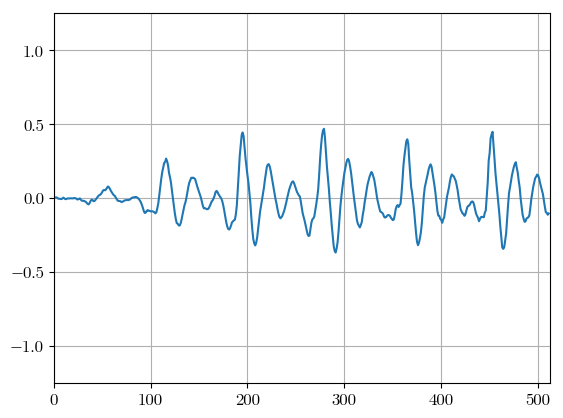

Reconstruction


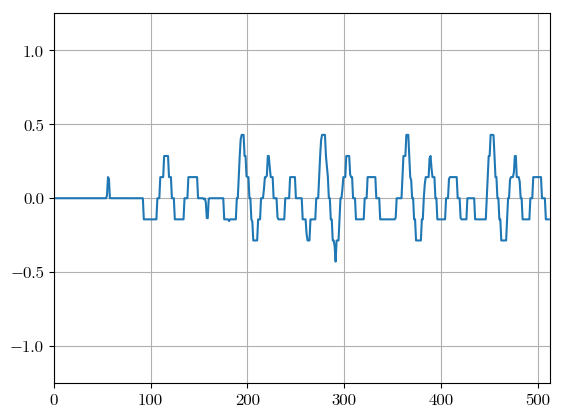

In [10]:
idx = 52

orig = X_train[idx].flatten()
recn = model.predict(X_train[idx:idx+1], verbose = 0)[0].flatten()

print "Original"
fancy_plot(orig, axes = False)

print "Reconstruction"
fancy_plot(recn, axes = False)

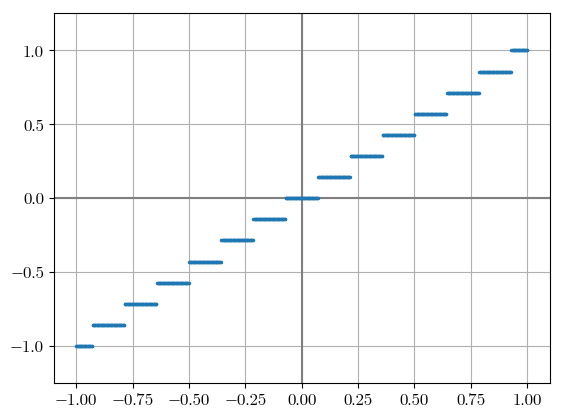

In [11]:
x = np.linspace(-1.0, 1.0, 800)

bins = K.eval(QUANT_BINS)
y = [bins[np.argmin(np.abs(bins - num))] for num in x]
fancy_plot(x, y, dots = True)

## After training

In [12]:
model.fit(X_train, [X_train] * n_losses, verbose = 1, epochs = 10, batch_size = 128)

Epoch 1/10
101544/101544 [==============================] - 3s - loss: 1.7381 - model_2_loss_1: 0.0104 - model_2_loss_2: 1.4253     
Epoch 2/10
101544/101544 [==============================] - 2s - loss: 1.3407 - model_2_loss_1: 0.0080 - model_2_loss_2: 1.0995     
Epoch 3/10
101544/101544 [==============================] - 2s - loss: 1.3191 - model_2_loss_1: 0.0085 - model_2_loss_2: 1.0628     
Epoch 4/10
101544/101544 [==============================] - 2s - loss: 1.3190 - model_2_loss_1: 0.0085 - model_2_loss_2: 1.0642     
Epoch 5/10
101544/101544 [==============================] - 2s - loss: 1.3187 - model_2_loss_1: 0.0085 - model_2_loss_2: 1.0623     
Epoch 6/10
101544/101544 [==============================] - 2s - loss: 1.3181 - model_2_loss_1: 0.0085 - model_2_loss_2: 1.0619     
Epoch 7/10
101544/101544 [==============================] - 2s - loss: 1.3186 - model_2_loss_1: 0.0086 - model_2_loss_2: 1.0595     
Epoch 8/10
101544/101544 [==============================] - 2s - loss

In [13]:
test_model_on_wav("./SA1.wav", "SA1_quant_after", model)

MSE:         11686.6
Avg err:     28.8783
PESQ:        2.14810156822


[11686.588, 28.87834, 2.148101568222046]

Original


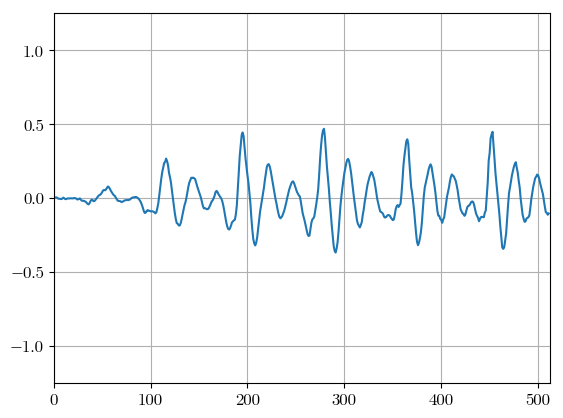

Reconstruction


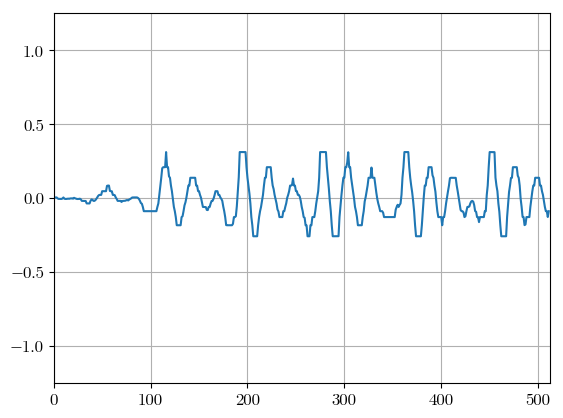

In [14]:
idx = 52

orig = X_train[idx].flatten()
recn = model.predict(X_train[idx:idx+1], verbose = 0)[0].flatten()

print "Original"
fancy_plot(orig, axes = False)

print "Reconstruction"
fancy_plot(recn, axes = False)

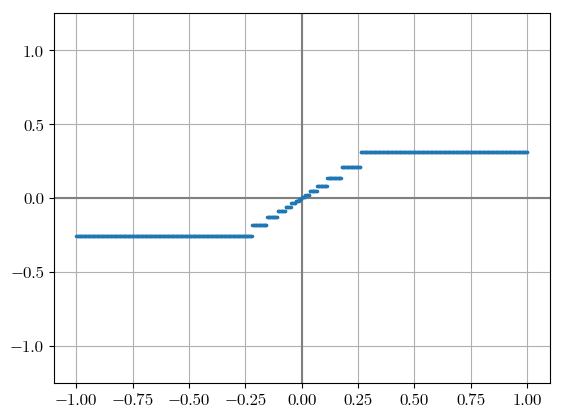

In [15]:
x = np.linspace(-1.0, 1.0, 800)

bins = K.eval(QUANT_BINS)
y = [bins[np.argmin(np.abs(bins - num))] for num in x]
fancy_plot(x, y, dots = True)